# **Plot skin friction *Cf* and pressure coefficient *Cp* where *Re* = 3.0e6**

Mesh settings in *blockMeshDict*
1. y+ = 0.05 : yGradAirfoil = 8000, yMid = 200, yTrail = 30
2. y+ = 1 : yGradAirfoil = 350, yMid = 200, yTrail = 30
3. y+ = 2 : yGradAirfoil = 150, yMid = 200, yTrail = 40
4. y+ = 3.5 : yGradAirfoil = 65, yMid = 200, yTrail = 40
5. y+ = 5 : yGradAirfoil = 50, yMid = 200, yTrail = 40
6. y+ = 10 : yGradAirfoil = 15, yMid = 200, yTrail = 40
7. y+ = 50 : yGradAirfoil = 1, yMid = 180, yTrail = 40
8. y+ = 100 : yGradAirfoil = 1, yMid = 100, yTrail = 40

The residual for *p*, *U*, and *nuTilda* is 1e-5.

In [1]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from flowtorch.data import CSVDataloader
from itertools import cycle

# increase dpi and use latex rendering
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 160
mpl.rc('text', usetex=True)

# Set macro for paths
run = "../run/"

In [2]:
UInf = 30.0
nuInf = 1.0e-05

model_sa = "SpalartAllmaras"
yp = ['0.05', '1', '2', '3.5', '5', '10', '50', '100']

casePath_noW = "airfoil/airFoil2D_Re3e6_alpha0_noWallFunc/"
casePath_withW = "airfoil/airFoil2D_Re3e6_alpha0_withWallFunc/"

casePath_wallCorr = "airfoil_ddwmSimpleFoam/airFoil2D_Re3e6_alpha0_ddwmSF_wallCorr/"
casePath_faceCorr = "airfoil_ddwmSimpleFoam/airFoil2D_Re3e6_alpha0_ddwmSF_faceCorr/"

In [3]:
# CFL3D data for Cf (only upper face of airfoil)
Cf_path = run + 'refData_Cf_alpha0_upper.csv'
Cf_refData = pd.read_csv(Cf_path)
Cf_refData.head()

,x,f
0,0.000028,0.000676
1,0.000137,0.001991
2,0.000351,0.003219
3,0.000673,0.004305
4,0.001102,0.005205


In [4]:
# Experimenal data for Cp (only upper face of airfoil)
Cp_path = run + 'refData_Cp_alpha0_upper.csv'
Cp_refData = pd.read_csv(Cp_path, delim_whitespace=True)
Cp_refData.head()

,x,f
0,0.000000,1.000000
1,0.002350,0.847673
2,0.004960,0.456198
3,0.005269,0.173569
4,0.014241,-0.044407


In [5]:
# The functions are referred to https://github.com/AndreWeiner/naca0012_shock_buffet/blob/main/notebooks/utils.py
def fetch_surface_data(path, remove_te=False):
    """Load and process surface sample data.
    The following processing is done:
    - split into lower and upper side
    - normalization of x with chord length
    - sorting of all fields according to x_*
    
    Parameters
    ----------
    path - str: path to csv file
    remove_te - bool: trailing edge data are removed if True
    
    Returns
    -------
    x_* - array: normalized coordinate value along the airfoil for lower and upper side    
    f_* - array: surface field for lower and upper side
    """
    d = pd.read_csv(path, sep=" ", header=None)
    # For Cf
    if (d.shape[1] > 3):
        data = pd.read_csv(path, sep=" ", skiprows=[
                           0], header=None, names=["x", "y", "tau_x", "tau_y", "tau_z"])
        data["f"] = np.sqrt(data['tau_x']**2 + data['tau_y']**2 + data['tau_z']**2)
        data = data.drop(["tau_x", "tau_y", "tau_z"], axis=1)
    # For Cp
    else:
        data = pd.read_csv(path, sep=" ", skiprows=[
                           0], header=None, names=["x", "y", "f"])
    x_max = data.x.max()
    limit = 0.999 if remove_te else 1.1
    x_up = data[(data.y >= 0) & (data.x < limit*x_max)].x
    x_up = x_up.values / x_max    
    f_up = data[(data.y >= 0) & (data.x < limit*x_max)].f.values
    x_low = data[(data.y < 0) & (data.x < limit*x_max)].x
    x_low = x_low.values / x_max    
    f_low = data[(data.y < 0) & (data.x < limit*x_max)].f.values
    ind_up = np.argsort(x_up)
    ind_low = np.argsort(x_low)
    return x_up[ind_up], f_up[ind_up], x_low[ind_low], f_low[ind_low]

def fetch_surface_data_solver(path, field_name, remove_te=False):
    """Load and process surface sample data.
    The following processing is done:
    - split into lower and upper side
    - normalization of x with chord length
    - sorting of all fields according to x_*
    
    Parameters
    ----------
    path - str: path to csv file
    field_name - str: give string information for fields
    remove_te - bool: trailing edge data are removed if True
    
    Returns
    -------
    x_* - array: normalized coordinate value along the airfoil for lower and upper side    
    f_* - array: surface field for lower and upper side
    """
    data = pd.read_csv(path)    
    if (field_name == 'Cf'):
        # For Cf
        data = data.rename(columns={'ccx': 'x', 'ccy': 'y', 'skinFriction': 'f'})        
    elif (field_name == 'Cp'):
        # For Cp
        data = data.rename(columns={'ccx': 'x', 'ccy': 'y', 'pressureCoeff': 'f'})
    
    x_max = data.x.max()
    limit = 0.999 if remove_te else 1.1
    x_up = data[(data.y >= 0) & (data.x < limit*x_max)].x
    x_up = x_up.values / x_max    
    f_up = data[(data.y >= 0) & (data.x < limit*x_max)].f.values
    x_low = data[(data.y < 0) & (data.x < limit*x_max)].x
    x_low = x_low.values / x_max    
    f_low = data[(data.y < 0) & (data.x < limit*x_max)].f.values
    ind_up = np.argsort(x_up)
    ind_low = np.argsort(x_low)
    return x_up[ind_up], f_up[ind_up], x_low[ind_low], f_low[ind_low]

In [6]:
# Cf data loading for the original solver
for i in range(len(yp)):    
    globals()['x_up_Cf_nowall{}'.format(i)], globals()['f_up_Cf_nowall{}'.format(i)], globals()['x_low_Cf_nowall{}'.format(i)], globals()['f_low_Cf_nowall{}'.format(i)] = fetch_surface_data(run + casePath_noW + 'yplus_{}/tauw_{}_{}.csv'.format(yp[i], model_sa, yp[i]), True)
    globals()['x_up_Cf_wall{}'.format(i)], globals()['f_up_Cf_wall{}'.format(i)], globals()['x_low_Cf_wall{}'.format(i)], globals()['f_low_Cf_wall{}'.format(i)] = fetch_surface_data(run + casePath_withW + 'yplus_{}/tauw_{}_{}.csv'.format(yp[i], model_sa, yp[i]), True)

In [7]:
# Cp data loading for the original solver
for i in range(len(yp)):    
    globals()['x_up_Cp_nowall{}'.format(i)], globals()['f_up_Cp_nowall{}'.format(i)], globals()['x_low_Cp_nowall{}'.format(i)], globals()['f_low_Cp_nowall{}'.format(i)] = fetch_surface_data(run + casePath_noW + 'yplus_{}/Cp_{}_{}.csv'.format(yp[i], model_sa, yp[i]), True)
    globals()['x_up_Cp_wall{}'.format(i)], globals()['f_up_Cp_wall{}'.format(i)], globals()['x_low_Cp_wall{}'.format(i)], globals()['f_low_Cp_wall{}'.format(i)] = fetch_surface_data(run + casePath_withW + 'yplus_{}/Cp_{}_{}.csv'.format(yp[i], model_sa, yp[i]), True)

In [8]:
# Cf data loading for the new solver
for i in range(len(yp)):    
    globals()['x_up_Cf_wallCorr{}'.format(i)], globals()['f_up_Cf_wallCorr{}'.format(i)], globals()['x_low_Cf_wallCorr{}'.format(i)], globals()['f_low_Cf_wallCorr{}'.format(i)] = fetch_surface_data_solver(run + casePath_wallCorr + 'yplus_{}/{}yp_surfaceFields.csv'.format(yp[i], yp[i]), 'Cf', True)
    globals()['x_up_Cf_faceCorr{}'.format(i)], globals()['f_up_Cf_faceCorr{}'.format(i)], globals()['x_low_Cf_faceCorr{}'.format(i)], globals()['f_low_Cf_faceCorr{}'.format(i)] = fetch_surface_data_solver(run + casePath_faceCorr + 'yplus_{}/{}yp_surfaceFields.csv'.format(yp[i], yp[i]), 'Cf', True)

In [9]:
# Cp data loading for the new solver
for i in range(len(yp)):    
    globals()['x_up_Cp_wallCorr{}'.format(i)], globals()['f_up_Cp_wallCorr{}'.format(i)], globals()['x_low_Cp_wallCorr{}'.format(i)], globals()['f_low_Cp_wallCorr{}'.format(i)] = fetch_surface_data_solver(run + casePath_wallCorr + 'yplus_{}/{}yp_surfaceFields.csv'.format(yp[i], yp[i]), 'Cp', True)
    globals()['x_up_Cp_faceCorr{}'.format(i)], globals()['f_up_Cp_faceCorr{}'.format(i)], globals()['x_low_Cp_faceCorr{}'.format(i)], globals()['f_low_Cp_faceCorr{}'.format(i)] = fetch_surface_data_solver(run + casePath_faceCorr + 'yplus_{}/{}yp_surfaceFields.csv'.format(yp[i], yp[i]), 'Cp', True)

## Plots for skin friction

- Line style for upper airfoil : " -. " and " -- "
- Line style for lower airfoils : all " : "

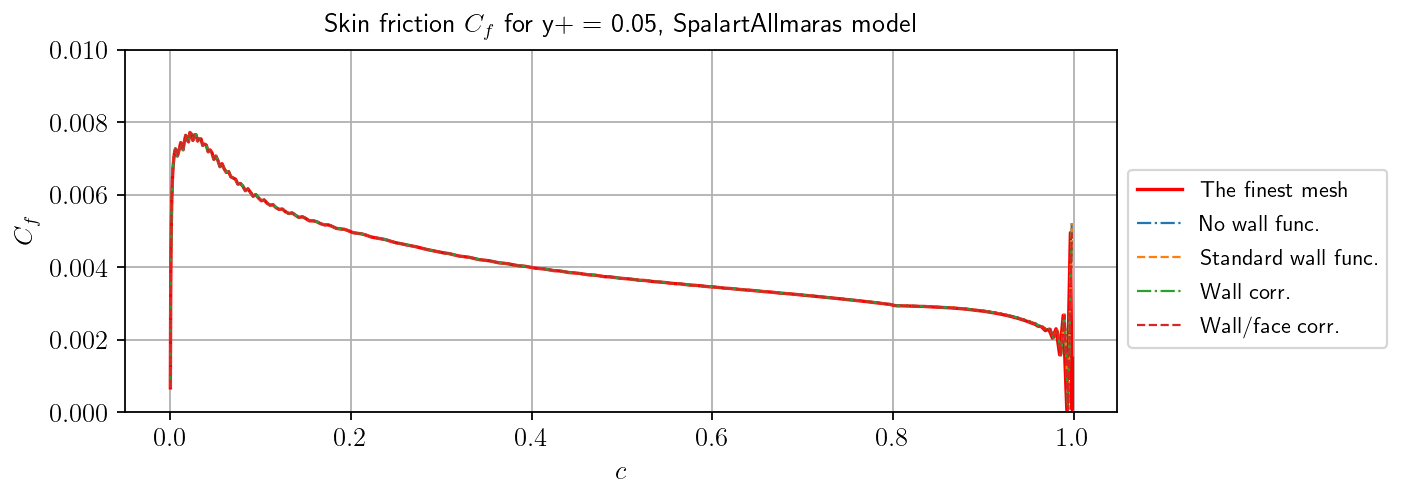

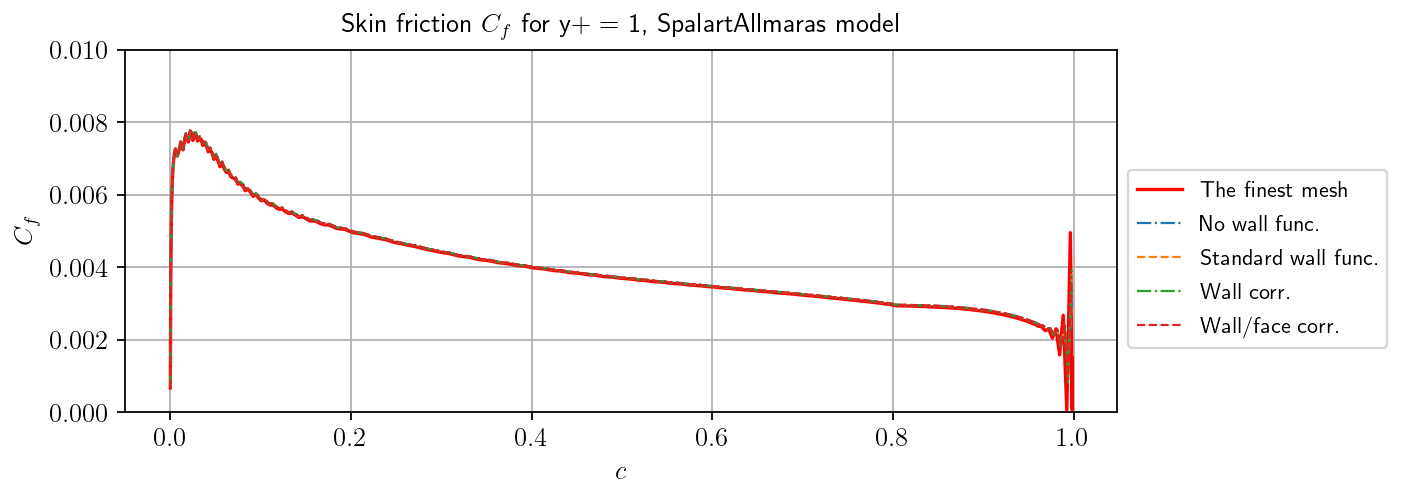

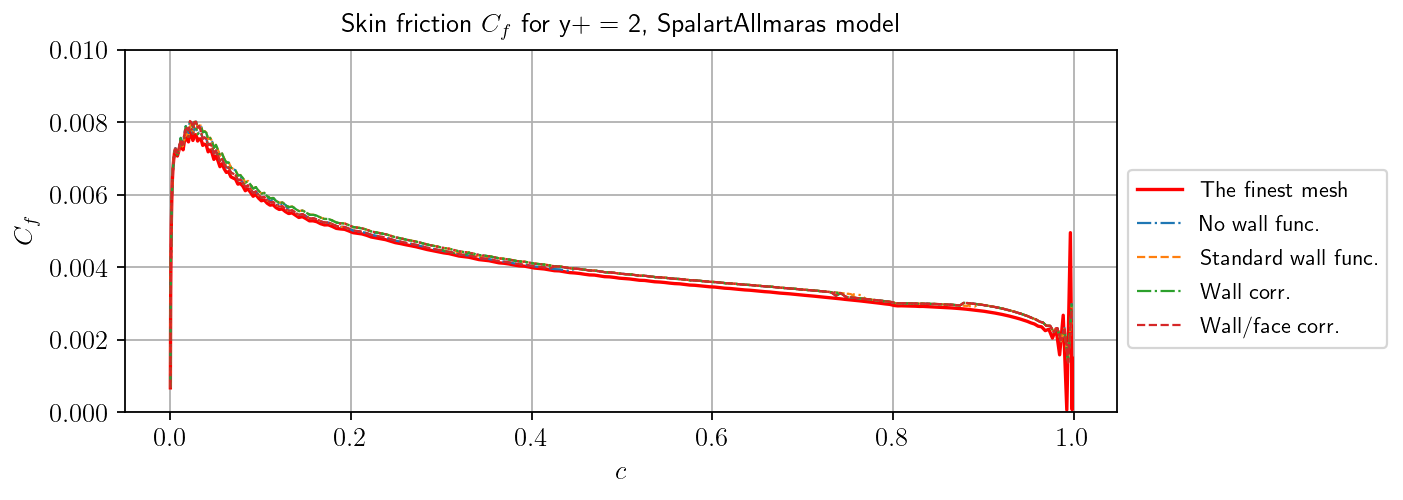

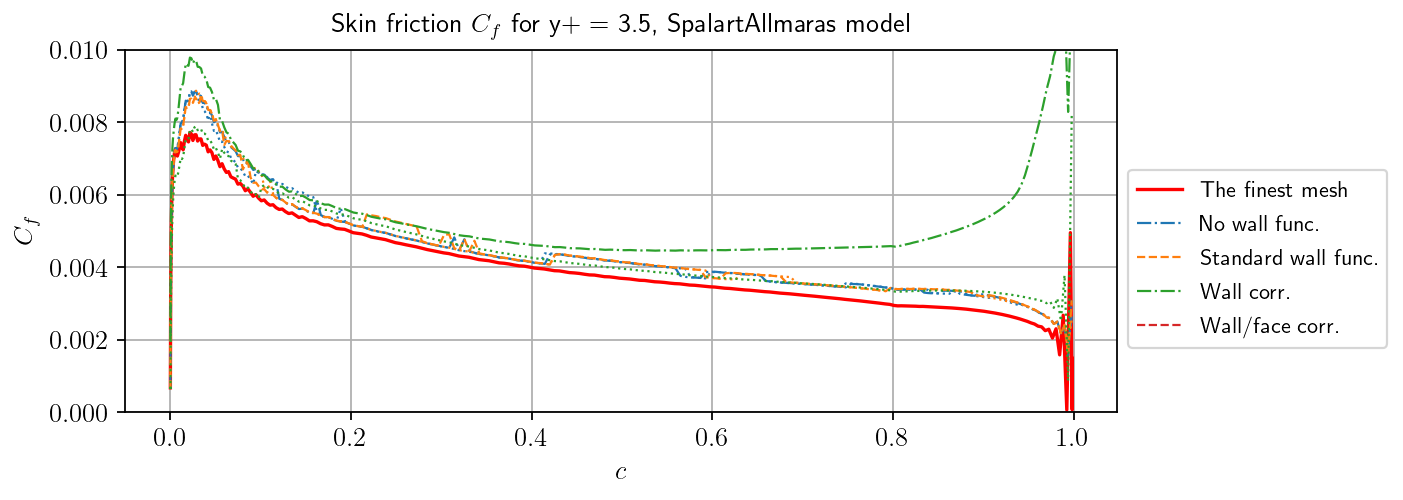

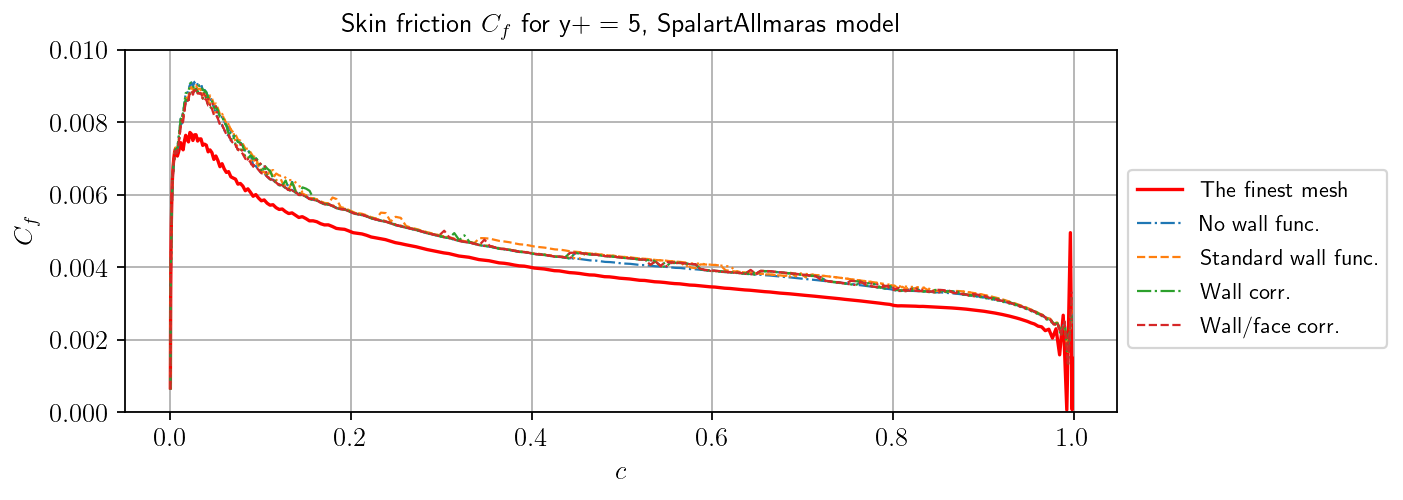

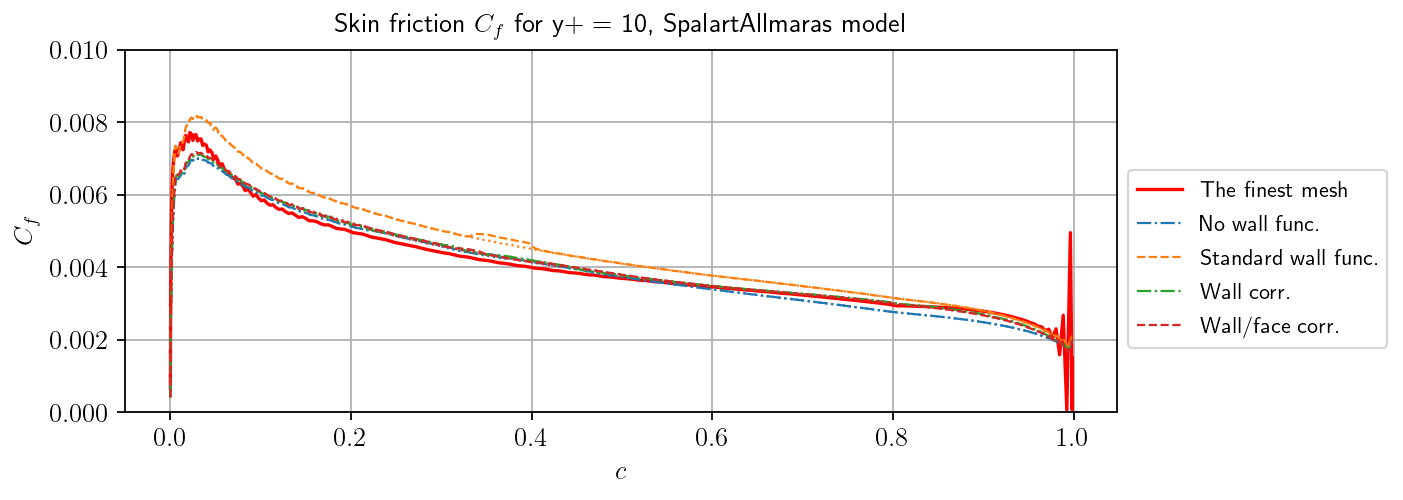

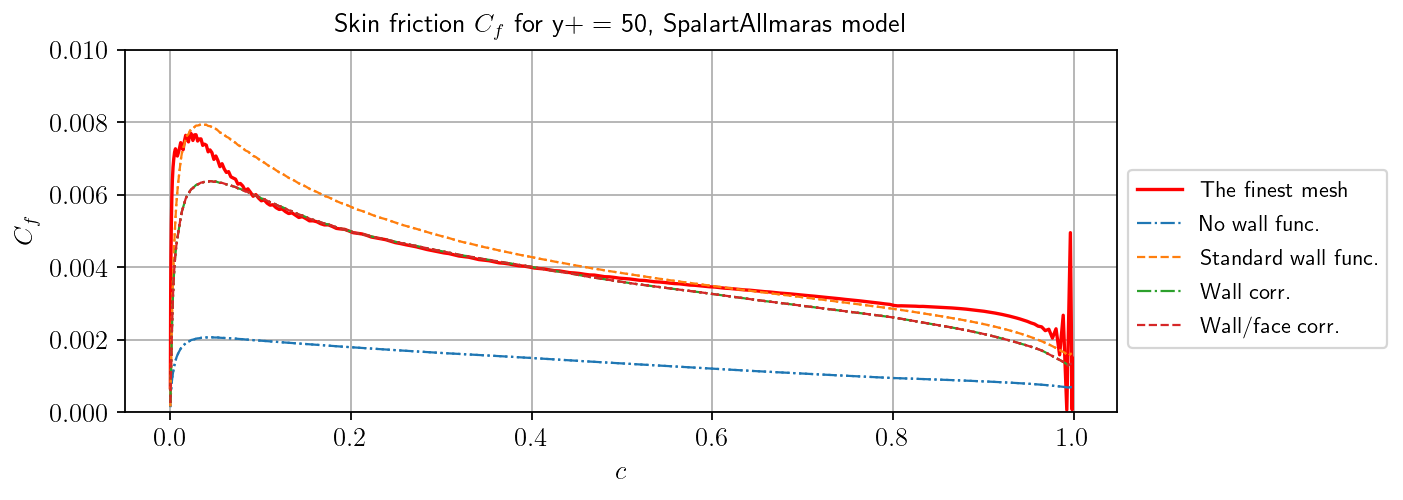

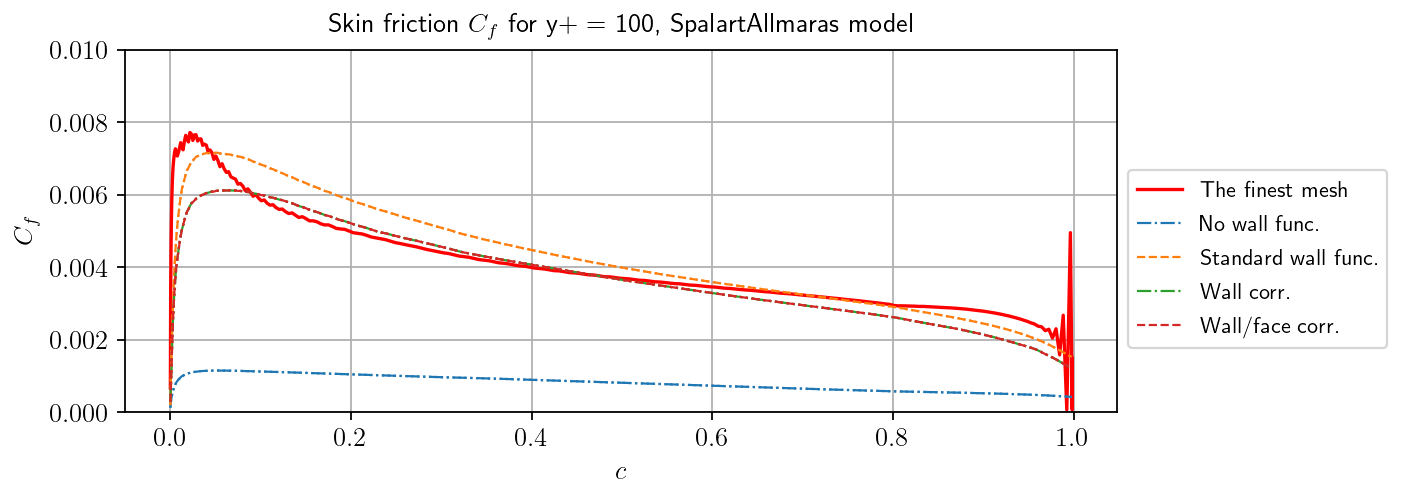

In [10]:
style = ["-", "-.", ":", "--"]
lw = 1.0

for i in range(len(yp)):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))    
    plt.ylim([0, 0.01])
    plt.grid()
    ax.set_xlabel(r"$c$", fontsize = 12)
    ax.set_ylabel(r"$C_f$", fontsize = 12)
    ax.tick_params(labelsize = 12)
    plt.title(r"Skin friction $C_f$ for y+ = {}, {} model".format(yp[i], model_sa))
    ax.plot(np.array(Cf_refData['x']), np.array(Cf_refData['f']), color = "r", label = "The finest mesh")
    ax.plot(globals()['x_up_Cf_nowall{}'.format(i)], globals()['f_up_Cf_nowall{}'.format(i)]/(0.5*UInf**2), label = "No wall func.", ls = style[1], c = "C{:d}".format(0), lw = lw)
    ax.plot(globals()['x_low_Cf_nowall{}'.format(i)], globals()['f_low_Cf_nowall{}'.format(i)]/(0.5*UInf**2), ls = style[2], c = "C{:d}".format(0), lw = lw)
    ax.plot(globals()['x_up_Cf_wall{}'.format(i)], globals()['f_up_Cf_wall{}'.format(i)]/(0.5*UInf**2), label = "Standard wall func.", ls = style[3], c = "C{:d}".format(1), lw = lw)
    ax.plot(globals()['x_low_Cf_wall{}'.format(i)], globals()['f_low_Cf_wall{}'.format(i)]/(0.5*UInf**2), ls = style[2], c = "C{:d}".format(1), lw = lw)
    ax.plot(globals()['x_up_Cf_wallCorr{}'.format(i)], globals()['f_up_Cf_wallCorr{}'.format(i)], label = "Wall corr.", ls = style[1], c = "C{:d}".format(2), lw = lw)
    ax.plot(globals()['x_low_Cf_wallCorr{}'.format(i)], globals()['f_low_Cf_wallCorr{}'.format(i)], ls = style[2], c = "C{:d}".format(2), lw = lw)
    ax.plot(globals()['x_up_Cf_faceCorr{}'.format(i)], globals()['f_up_Cf_faceCorr{}'.format(i)], label = "Wall/face corr.", ls = style[3], c = "C{:d}".format(3), lw = lw)
    ax.plot(globals()['x_low_Cf_faceCorr{}'.format(i)], globals()['f_low_Cf_faceCorr{}'.format(i)], ls = style[2], c = "C{:d}".format(3), lw = lw)
    ax.legend(fontsize = 10, bbox_to_anchor=(1, 0.7))
    plt.savefig("output/2Dairfoil/yp{}_Cf_Re3e6_airfoil.pdf".format(yp[i]), bbox_inches="tight")

## Plots for pressure coefficient

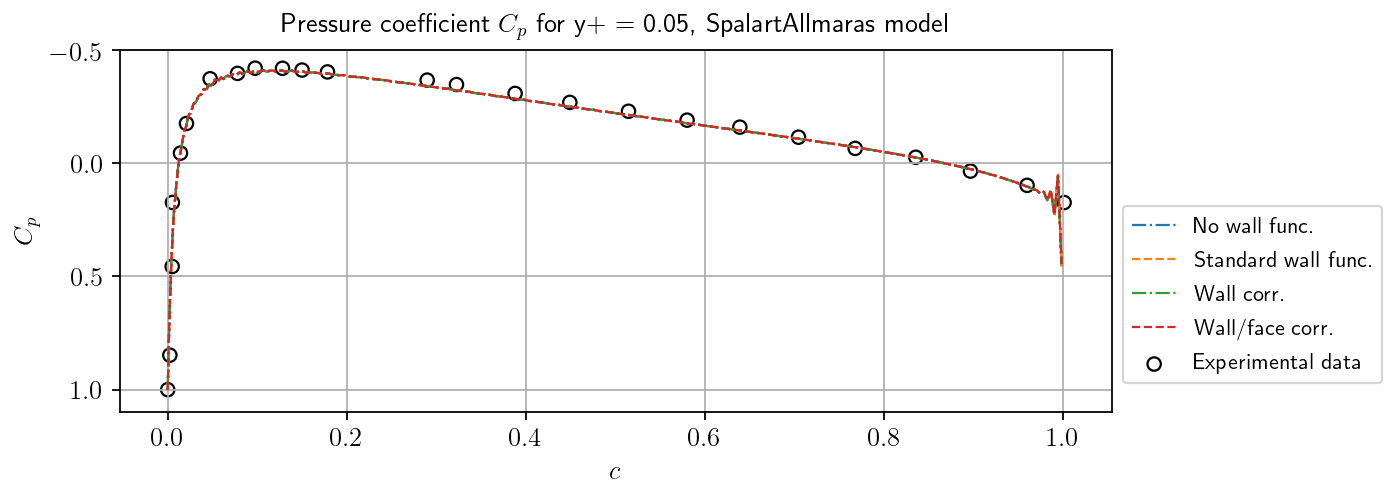

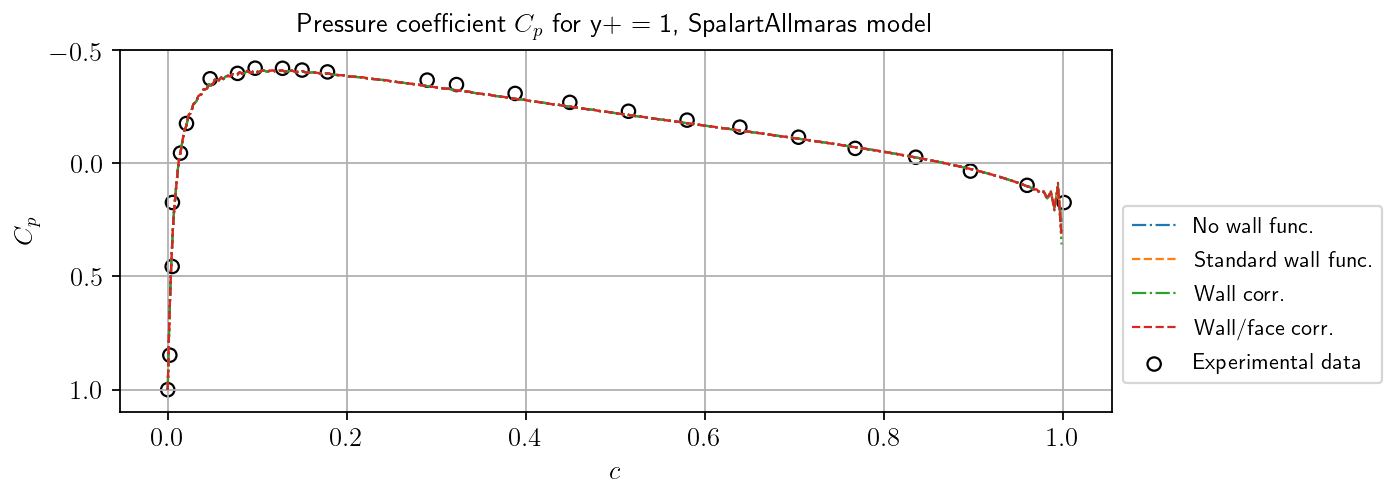

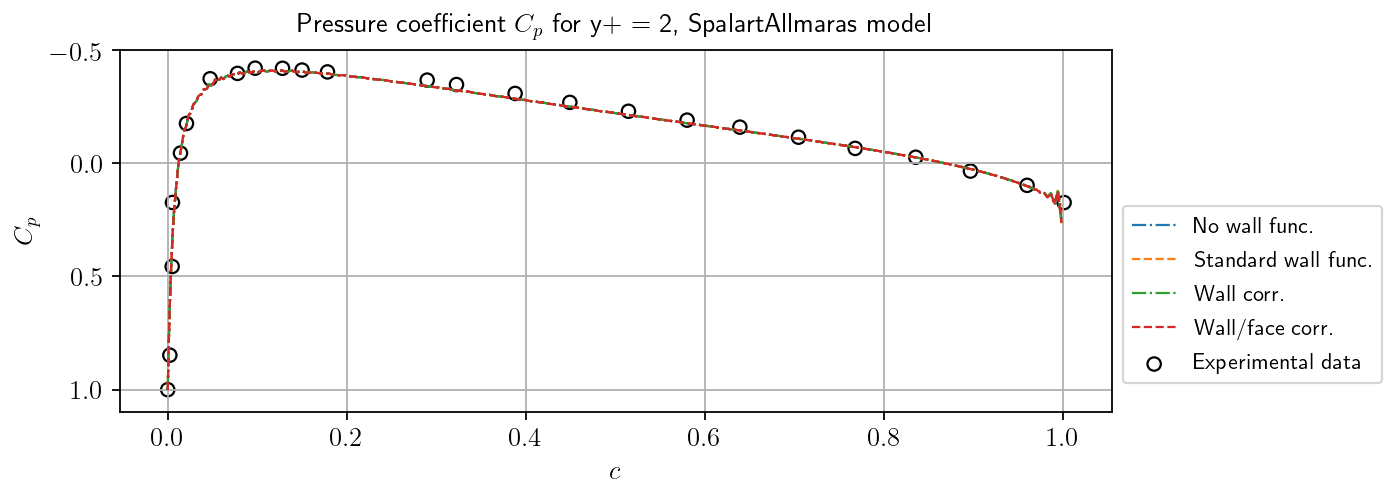

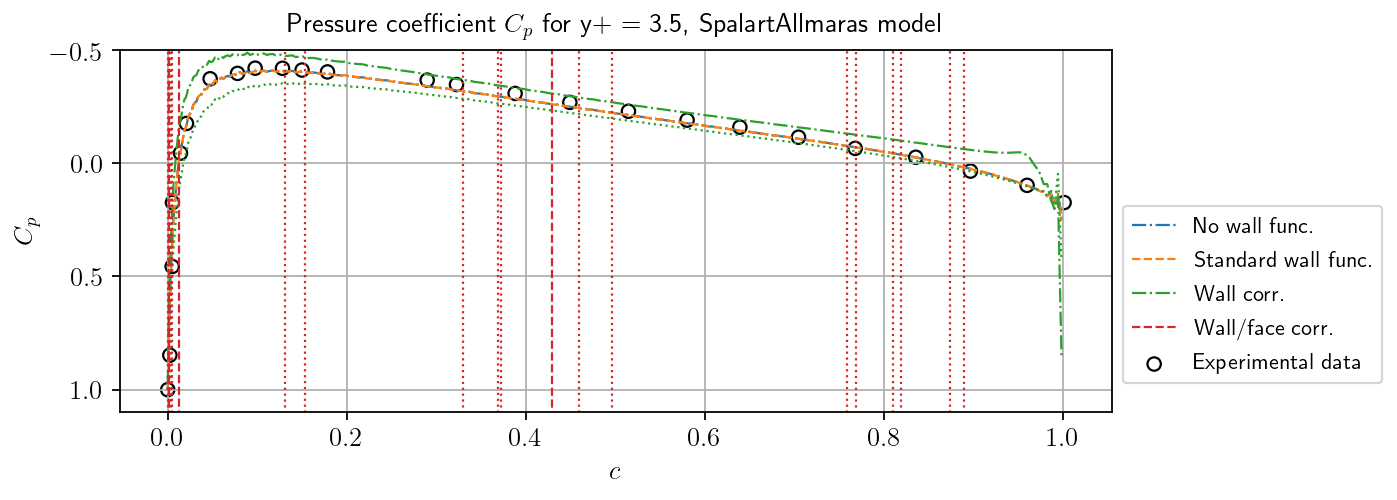

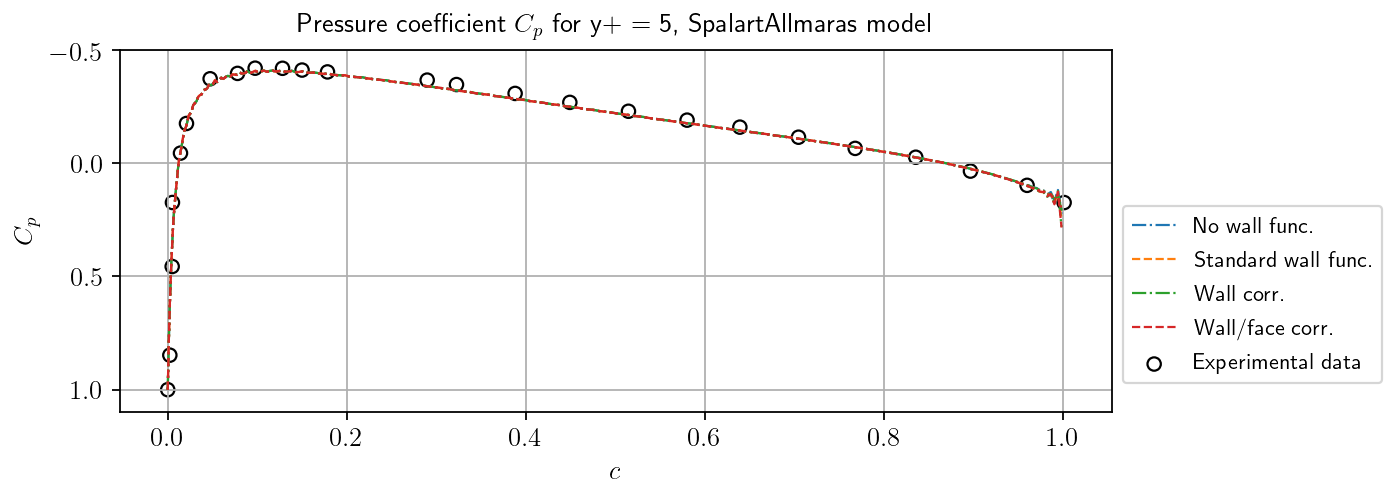

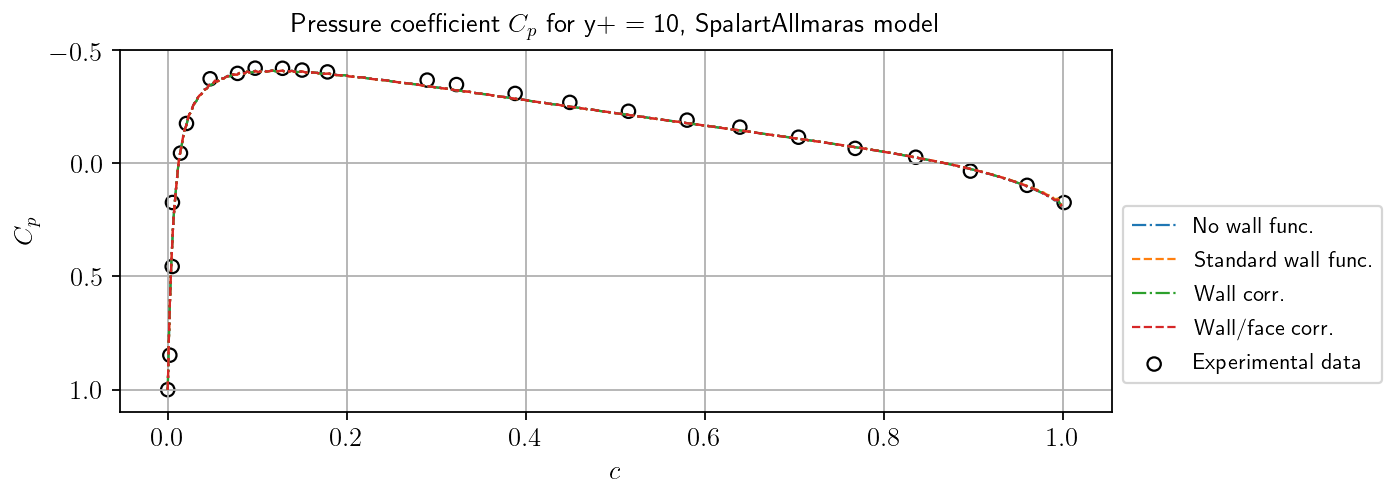

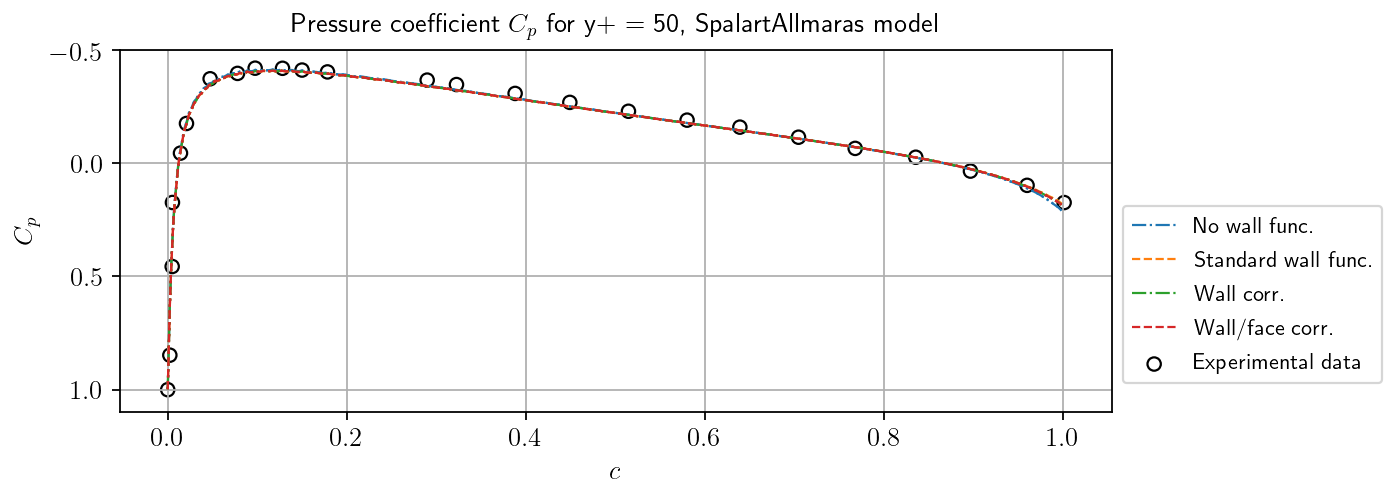

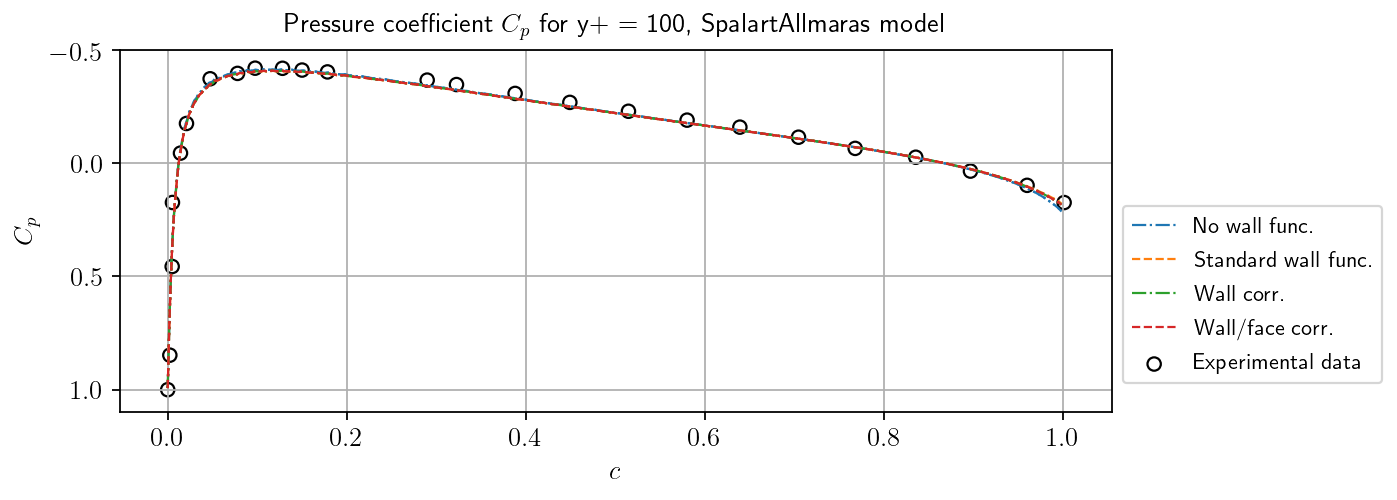

In [11]:
for i in range(len(yp)):
    fig2, ax2 = plt.subplots(1, 1, figsize=(8, 3))
    plt.ylim([-0.5, 1.1])
    plt.grid()
    ax2.set_xlabel(r"$c$", fontsize = 12)
    ax2.set_ylabel(r"$C_p$", fontsize = 12)
    ax2.tick_params(labelsize = 12)
    plt.title(r"Pressure coefficient $C_p$ for y+ = {}, {} model".format(yp[i], model_sa))
    ax2.invert_yaxis()
    ax2.scatter(np.array(Cp_refData['x']), np.array(Cp_refData['f']), marker="o", color="k", lw = lw, facecolor = "none", label = "Experimental data")
    ax2.plot(globals()['x_up_Cp_nowall{}'.format(i)], globals()['f_up_Cp_nowall{}'.format(i)], label = "No wall func.", ls = style[1], c = "C{:d}".format(0), lw = lw)
    ax2.plot(globals()['x_low_Cp_nowall{}'.format(i)], globals()['f_low_Cp_nowall{}'.format(i)], ls = style[2], c = "C{:d}".format(0), lw = lw)
    ax2.plot(globals()['x_up_Cp_wall{}'.format(i)], globals()['f_up_Cp_wall{}'.format(i)], label = "Standard wall func.", ls = style[3], c = "C{:d}".format(1), lw = lw)
    ax2.plot(globals()['x_low_Cp_wall{}'.format(i)], globals()['f_low_Cp_wall{}'.format(i)], ls = style[2], c = "C{:d}".format(1), lw = lw)
    ax2.plot(globals()['x_up_Cp_wallCorr{}'.format(i)], globals()['f_up_Cp_wallCorr{}'.format(i)], label = "Wall corr.", ls = style[1], c = "C{:d}".format(2), lw = lw)
    ax2.plot(globals()['x_low_Cp_wallCorr{}'.format(i)], globals()['f_low_Cp_wallCorr{}'.format(i)], ls = style[2], c = "C{:d}".format(2), lw = lw)
    ax2.plot(globals()['x_up_Cp_faceCorr{}'.format(i)], globals()['f_up_Cp_faceCorr{}'.format(i)], label = "Wall/face corr.", ls = style[3], c = "C{:d}".format(3), lw = lw)
    ax2.plot(globals()['x_low_Cp_faceCorr{}'.format(i)], globals()['f_low_Cp_faceCorr{}'.format(i)], ls = style[2], c = "C{:d}".format(3), lw = lw)
    ax2.legend(fontsize = 10, bbox_to_anchor=(1, 0.6))
    plt.savefig("output/2Dairfoil/yp{}_Cp_Re3e6_airfoil.pdf".format(yp[i]), bbox_inches="tight")

### Comparison *Cf* of the case without wall function for different *y+*

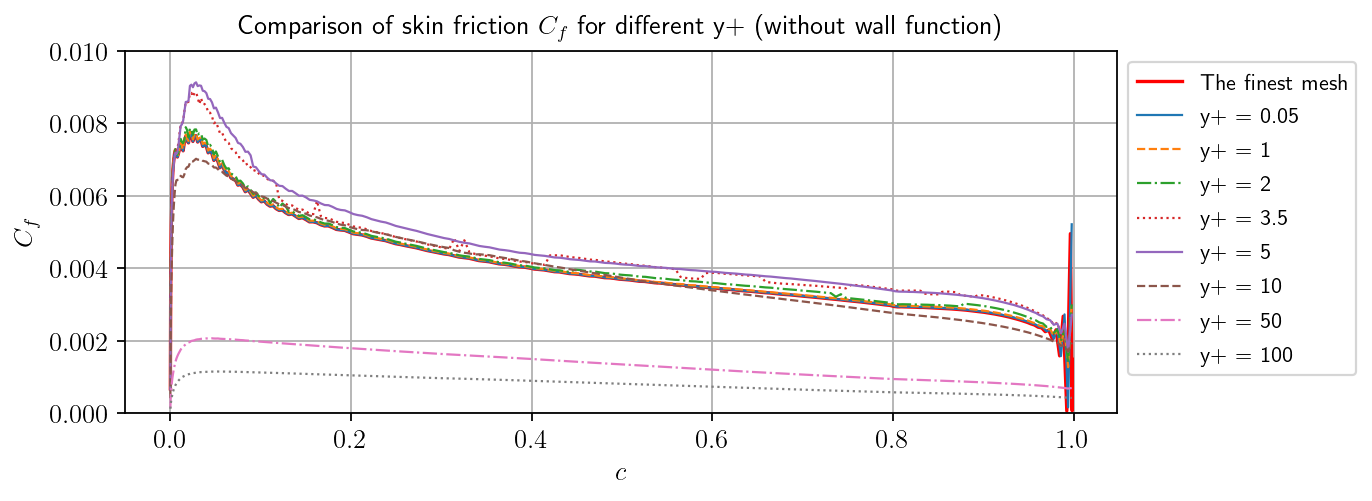

In [12]:
style2 = ["-", "--", "-.", ":"]
lw2 = 1.0
stylecycler = cycle(style2)

fig3, ax3 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.01])
plt.grid()
ax3.set_xlabel(r"$c$", fontsize = 12)
ax3.set_ylabel(r"$C_f$", fontsize = 12)
ax3.tick_params(labelsize = 12)
plt.title(r"Comparison of skin friction $C_f$ for different y+ (without wall function)")
ax3.plot(np.array(Cf_refData['x']), np.array(Cf_refData['f']), color = "r", label = "The finest mesh")
for i in range(len(yp)):
    ax3.plot(globals()['x_up_Cf_nowall{}'.format(i)], globals()['f_up_Cf_nowall{}'.format(i)]/(0.5*UInf**2), label = "y+ = {}".format(yp[i]), ls = next(stylecycler), c = "C{:d}".format(i), lw = lw2)
    ax3.legend(fontsize = 10, bbox_to_anchor=(1, 1))
plt.savefig("output/2Dairfoil/Cf_Re3e6_airfoil_nowallfunc.pdf", bbox_inches="tight")

### Comparison *Cf* of the case with wall function for different *y+*

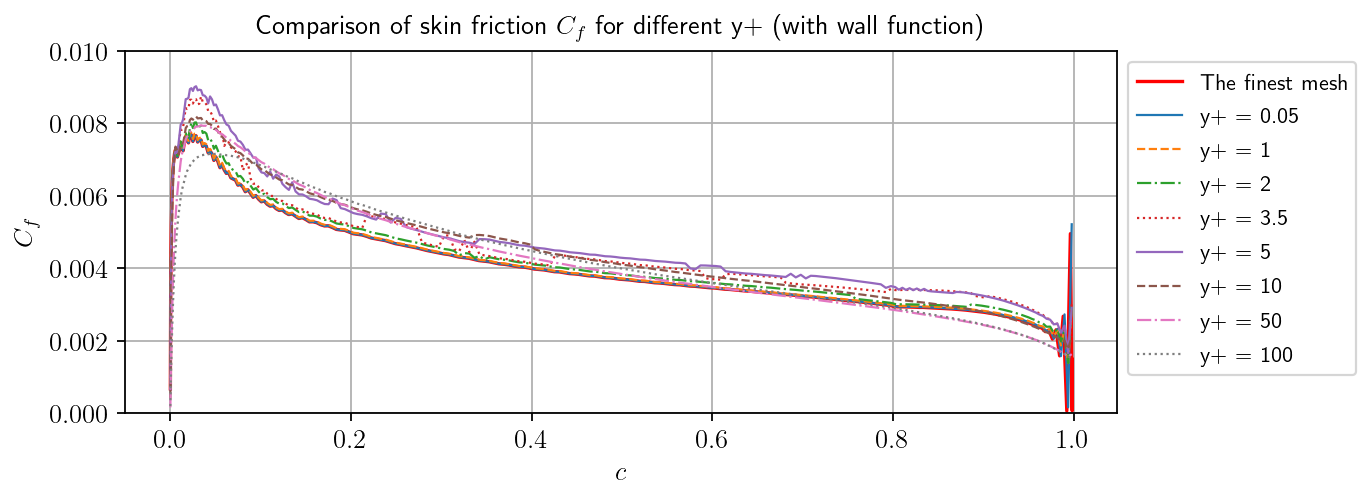

In [13]:
fig4, ax4 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.01])
plt.grid()
ax4.set_xlabel(r"$c$", fontsize = 12)
ax4.set_ylabel(r"$C_f$", fontsize = 12)
ax4.tick_params(labelsize = 12)
plt.title(r"Comparison of skin friction $C_f$ for different y+ (with wall function)")
ax4.plot(np.array(Cf_refData['x']), np.array(Cf_refData['f']), color = "r", label = "The finest mesh")
for i in range(len(yp)):
    ax4.plot(globals()['x_up_Cf_wall{}'.format(i)], globals()['f_up_Cf_wall{}'.format(i)]/(0.5*UInf**2), label = "y+ = {}".format(yp[i]), ls = next(stylecycler), c = "C{:d}".format(i), lw = lw2)
    ax4.legend(fontsize = 10, bbox_to_anchor=(1, 1))
plt.savefig("output/2Dairfoil/Cf_Re3e6_airfoil_standardwallfunc.pdf", bbox_inches="tight")

### Comparison *Cf* of data-driven wall modeling with the correction at the wall for different *y+*

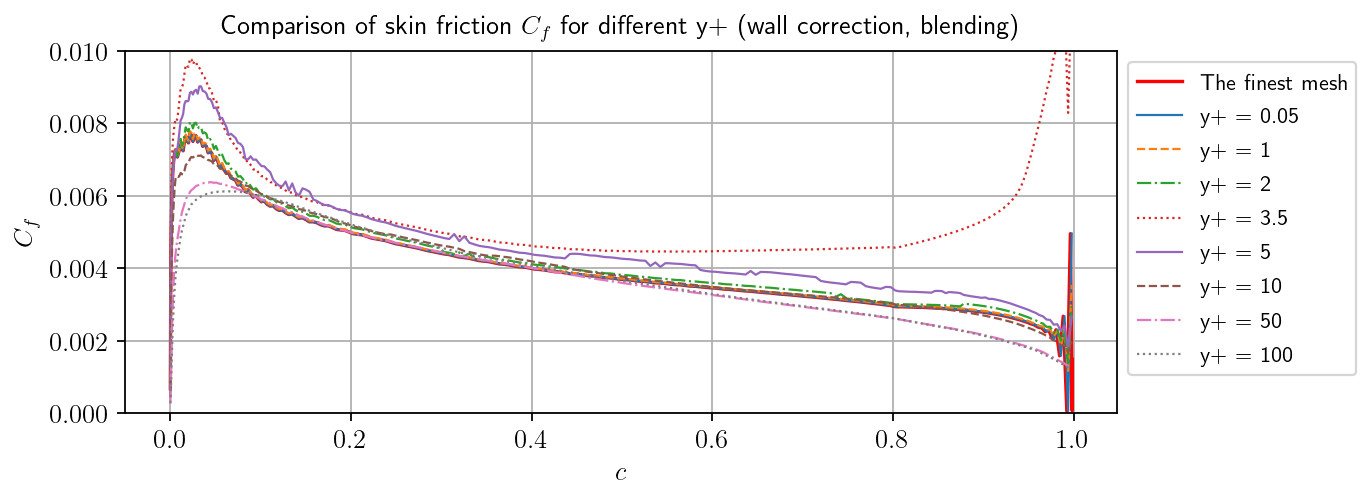

In [14]:
fig5, ax5 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.01])
plt.grid()
ax5.set_xlabel(r"$c$", fontsize = 12)
ax5.set_ylabel(r"$C_f$", fontsize = 12)
ax5.tick_params(labelsize = 12)
plt.title(r"Comparison of skin friction $C_f$ for different y+ (wall correction, blending)")
ax5.plot(np.array(Cf_refData['x']), np.array(Cf_refData['f']), color = "r", label = "The finest mesh")
for i in range(len(yp)):
    ax5.plot(globals()['x_up_Cf_wallCorr{}'.format(i)], globals()['f_up_Cf_wallCorr{}'.format(i)], label = "y+ = {}".format(yp[i]), ls = next(stylecycler), c = "C{:d}".format(i), lw = lw2)
    ax5.legend(fontsize = 10, bbox_to_anchor=(1, 1))
plt.savefig("output/2Dairfoil/Cf_Re3e6_airfoil_wallcorr.pdf", bbox_inches="tight")

### Comparison *Cf* of data-driven wall modeling with the correction at the first face for different *y+*

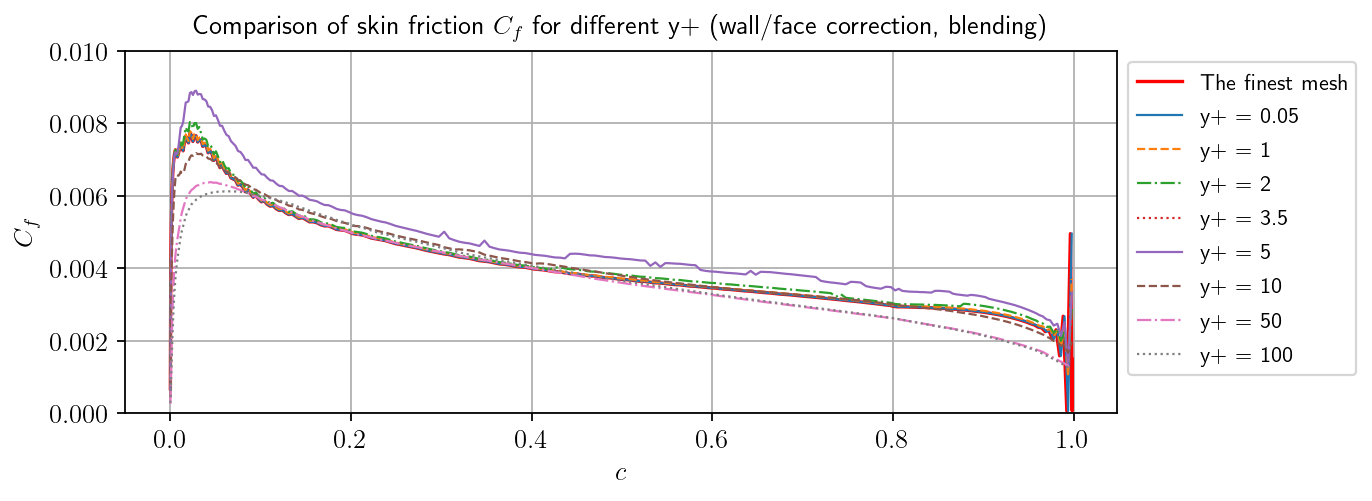

In [15]:
fig6, ax6 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.01])
plt.grid()
ax6.set_xlabel(r"$c$", fontsize = 12)
ax6.set_ylabel(r"$C_f$", fontsize = 12)
ax6.tick_params(labelsize = 12)
plt.title(r"Comparison of skin friction $C_f$ for different y+ (wall/face correction, blending)")
ax6.plot(np.array(Cf_refData['x']), np.array(Cf_refData['f']), color = "r", label = "The finest mesh")
for i in range(len(yp)):
    ax6.plot(globals()['x_up_Cf_faceCorr{}'.format(i)], globals()['f_up_Cf_faceCorr{}'.format(i)], label = "y+ = {}".format(yp[i]), ls = next(stylecycler), c = "C{:d}".format(i), lw = lw2)
    ax6.legend(fontsize = 10, bbox_to_anchor=(1, 1))
plt.savefig("output/2Dairfoil/Cf_Re3e6_airfoil_facecorr.pdf", bbox_inches="tight")

### Comparison of Cf between standard wall function and data-driven wall model

In [16]:
# Index except the case y+ = 3.5
m_index = [0, 1, 2, 4, 5, 6, 7]

mean_Cf_nowall = np.zeros((globals()['f_up_Cf_nowall{}'.format(0)].shape[0]))
mean_Cf_wall = np.zeros((globals()['f_up_Cf_wall{}'.format(0)].shape[0]))
mean_Cf_ddwall = np.zeros((globals()['f_up_Cf_wallCorr{}'.format(0)].shape[0]))
mean_Cf_ddface = np.zeros((globals()['f_up_Cf_faceCorr{}'.format(0)].shape[0]))
for j in range(globals()['f_up_Cf_nowall{}'.format(0)].shape[0]):
    mean_Cf_nowall[j] = np.array([globals()['f_up_Cf_nowall{}'.format(i)][j]/(0.5*UInf**2) for i in m_index]).mean()
    mean_Cf_wall[j] = np.array([globals()['f_up_Cf_wall{}'.format(i)][j]/(0.5*UInf**2) for i in m_index]).mean()
    mean_Cf_ddwall[j] = np.array([globals()['f_up_Cf_wallCorr{}'.format(i)][j] for i in m_index]).mean()
    mean_Cf_ddface[j] = np.array([globals()['f_up_Cf_faceCorr{}'.format(i)][j] for i in m_index]).mean()

In [17]:
std_Cf_nowall = np.zeros((globals()['f_up_Cf_nowall{}'.format(0)].shape[0]))
std_Cf_wall = np.zeros((globals()['f_up_Cf_wall{}'.format(0)].shape[0]))
std_Cf_ddwall = np.zeros((globals()['f_up_Cf_wallCorr{}'.format(0)].shape[0]))
std_Cf_ddface = np.zeros((globals()['f_up_Cf_faceCorr{}'.format(0)].shape[0]))
for j in range(globals()['f_up_Cf_nowall{}'.format(0)].shape[0]):
    std_Cf_nowall[j] = np.std(np.array([globals()['f_up_Cf_nowall{}'.format(i)][j]/(0.5*UInf**2) for i in m_index]))
    std_Cf_wall[j] = np.std(np.array([globals()['f_up_Cf_wall{}'.format(i)][j]/(0.5*UInf**2) for i in m_index]))
    std_Cf_ddwall[j] = np.std(np.array([globals()['f_up_Cf_wallCorr{}'.format(i)][j] for i in m_index]))
    std_Cf_ddface[j] = np.std(np.array([globals()['f_up_Cf_faceCorr{}'.format(i)][j] for i in m_index]))

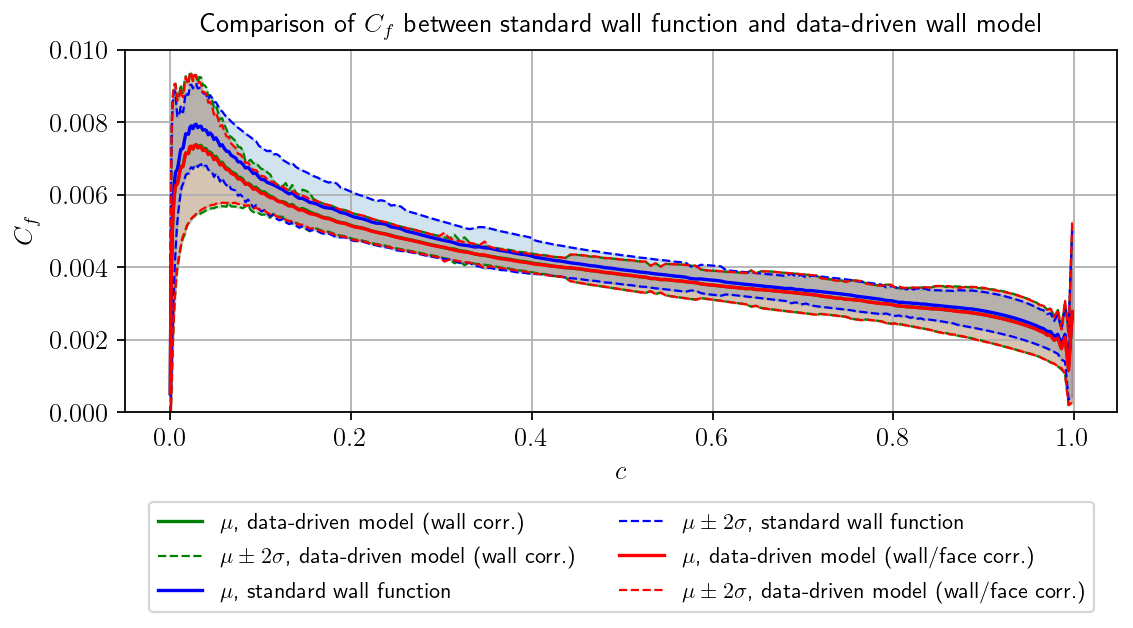

In [18]:
style3 = ["-", "--", ":"]
lw3 = 1.0

fig7, ax7 = plt.subplots(1, 1, figsize=(8, 3))
plt.ylim([0, 0.01])
plt.grid()
ax7.set_xlabel(r"$c$", fontsize = 12)
ax7.set_ylabel(r"$C_f$", fontsize = 12)
ax7.tick_params(labelsize = 12)
plt.title(r"Comparison of $C_f$ between standard wall function and data-driven wall model")
ax7.plot(globals()['x_up_Cf_wallCorr{}'.format(0)], mean_Cf_ddwall, color = "g", label = r"$\mu$, data-driven model (wall corr.)")
ax7.plot(globals()['x_up_Cf_wallCorr{}'.format(0)], mean_Cf_ddwall - 2*std_Cf_ddwall, ls = style3[1], c = "g", lw = lw3)
ax7.plot(globals()['x_up_Cf_wallCorr{}'.format(0)], mean_Cf_ddwall + 2*std_Cf_ddwall, label = r"$\mu\pm 2\sigma$, data-driven model (wall corr.)", ls = style3[1], c = "g", lw = lw3)
plt.fill_between(globals()['x_up_Cf_wallCorr{}'.format(0)], mean_Cf_ddwall - 2*std_Cf_ddwall, mean_Cf_ddwall + 2*std_Cf_ddwall, color = "C{:d}".format(2), alpha=0.2)
ax7.plot(globals()['x_up_Cf_wall{}'.format(0)], mean_Cf_wall, color = "b", label = r"$\mu$, standard wall function")
ax7.plot(globals()['x_up_Cf_wall{}'.format(0)], mean_Cf_wall - 2*std_Cf_wall, ls = style3[1], c = "b", lw = lw3)
ax7.plot(globals()['x_up_Cf_wall{}'.format(0)], mean_Cf_wall + 2*std_Cf_wall, label = r"$\mu\pm 2\sigma$, standard wall function", ls = style3[1], c = "b", lw = lw3)
plt.fill_between(globals()['x_up_Cf_wall{}'.format(0)], mean_Cf_wall - 2*std_Cf_wall, mean_Cf_wall + 2*std_Cf_wall, color = "C{:d}".format(0), alpha=0.2)
ax7.plot(globals()['x_up_Cf_faceCorr{}'.format(0)], mean_Cf_ddface, color = "r", label = r"$\mu$, data-driven model (wall/face corr.)")
ax7.plot(globals()['x_up_Cf_faceCorr{}'.format(0)], mean_Cf_ddface - 2*std_Cf_ddface, ls = style3[1], c = "r", lw = lw3)
ax7.plot(globals()['x_up_Cf_faceCorr{}'.format(0)], mean_Cf_ddface + 2*std_Cf_ddface, label = r"$\mu\pm 2\sigma$, data-driven model (wall/face corr.)", ls = style3[1], c = "r", lw = lw3)
plt.fill_between(globals()['x_up_Cf_faceCorr{}'.format(0)], mean_Cf_ddface - 2*std_Cf_ddface, mean_Cf_ddface + 2*std_Cf_ddface, color = "C{:d}".format(3), alpha=0.2)
ax7.legend(ncol=2, fontsize = 10, bbox_to_anchor=(0.5, -0.4), loc='center')
plt.savefig("output/2Dairfoil/Cf_Re3e6_airfoil_stdev.pdf", bbox_inches="tight")

In [19]:
repValue_Cf_nowall = mean_Cf_nowall.mean()
repValue_Cf_wall = mean_Cf_wall.mean()
repValue_Cf_ddwall = mean_Cf_ddwall.mean()
repValue_Cf_ddface = mean_Cf_ddface.mean()

repStd_Cf_nowall = std_Cf_nowall.mean()
repStd_Cf_wall = std_Cf_wall.mean()
repStd_Cf_ddwall = std_Cf_ddwall.mean()
repStd_Cf_ddface = std_Cf_ddface.mean()

In [20]:
# Representative mean value with 95% credible interval
print("Mean +- 2*std = {:.6f} +- {:.6f} (No wall func.)".format(repValue_Cf_nowall, 2*repStd_Cf_nowall))
print("Mean +- 2*std = {:.6f} +- {:.6f} (Standard wall func.)".format(repValue_Cf_wall, 2*repStd_Cf_wall))
print("Mean +- 2*std = {:.6f} +- {:.6f} (Wall corr.)".format(repValue_Cf_ddwall, 2*repStd_Cf_ddwall))
print("Mean +- 2*std = {:.6f} +- {:.6f} (Wall/face corr.)".format(repValue_Cf_ddface, 2*repStd_Cf_ddface))

Mean +- 2*std = 0.003531 +- 0.003122 (No wall func.)
Mean +- 2*std = 0.004578 +- 0.000701 (Standard wall func.)
Mean +- 2*std = 0.004355 +- 0.000782 (Wall corr.)
Mean +- 2*std = 0.004345 +- 0.000760 (Wall/face corr.)


## y+ calculation

In [21]:
# No wall function
yplus_data = [run + casePath_noW + 'postProcessing-{}_{}/surface/'.format(model_sa, yp[i]) for i in range(len(yp))]
yplus_loader = [CSVDataloader.from_foam_surface(yplus_data[i], "yPlus_airfoil.raw", "yplus") for i in range(len(yp))]

In [22]:
times = [yplus_loader[i].write_times for i in range(len(yp))]
yp_snapshots = [yplus_loader[i].load_snapshot("yplus", times[i][-1]) for i in range(len(yp))]
yp_snapshots[-1].shape

torch.Size([1040])

In [23]:
for i in range(len(yp)):
    print("yp = {}, actual mean yp = {}".format(yp[i], yp_snapshots[i].mean()))

yp = 0.05, actual mean yp = 0.06217380240559578
yp = 1, actual mean yp = 0.9204475283622742
yp = 2, actual mean yp = 1.856975793838501
yp = 3.5, actual mean yp = 3.6928935050964355
yp = 5, actual mean yp = 4.553296089172363
yp = 10, actual mean yp = 10.145834922790527
yp = 50, actual mean yp = 34.750572204589844
yp = 100, actual mean yp = 49.0150032043457


In [24]:
# With wall function
yplus_data2 = [run + casePath_withW + 'postProcessing-{}_{}/surface/'.format(model_sa, yp[i]) for i in range(len(yp))]
yplus_loader2 = [CSVDataloader.from_foam_surface(yplus_data2[i], "yPlus_airfoil.raw", "yplus2") for i in range(len(yp))]

In [25]:
times2 = [yplus_loader2[i].write_times for i in range(len(yp))]
yp_snapshots2 = [yplus_loader2[i].load_snapshot("yplus2", times2[i][-1]) for i in range(len(yp))]
yp_snapshots2[-1].shape

torch.Size([1040])

In [26]:
for i in range(len(yp)):
    print("yp = {}, actual mean yp = {}".format(yp[i], yp_snapshots2[i].mean()))

yp = 0.05, actual mean yp = 0.06216062605381012
yp = 1, actual mean yp = 0.9133620858192444
yp = 2, actual mean yp = 1.8245116472244263
yp = 3.5, actual mean yp = 3.690357208251953
yp = 5, actual mean yp = 4.582324028015137
yp = 10, actual mean yp = 10.709986686706543
yp = 50, actual mean yp = 59.98969268798828
yp = 100, actual mean yp = 108.99757385253906
